In [1]:
# #deal with null values
# df_copy['Embarked'] = df_copy['Embarked'].fillna("Unknown")
# df_copy['Age'] = df_copy['Age'].fillna(df_copy['Age'].median()) 
# df_copy.isnull().sum()

# #df_copy.dropna(axis=1).to_csv("TitanicDropCols.csv",index=False)
# df_copy.to_csv("TitanicHandlingNull.csv", index=False)

In [2]:
import numpy as np 
import pandas as pd 
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import git
import dvc.api
import mlflow
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_log_error 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        


In [3]:
repo = git.Repo(r"Z:\Workspace\ITi\Data Science in Production\TitanicMlflowProject\.git")

def print_repository_info(repo):
    print('Repository description: {}'.format(repo.description))
    print('Repository active branch is {}'.format(repo.active_branch))

    for remote in repo.remotes:
        print('Remote named "{}" with URL "{}"'.format(remote, remote.url))

    print('Last commit for repository is {}.'.format(str(repo.head.commit.hexsha)))

    
def print_commit_data(commit, req_ver):

    print('-----')
    print(str(commit.hexsha))
    print("\"{}\" by {} ({})".format(commit.summary, commit.author.name, commit.author.email))
    print(str(commit.authored_datetime))
    print(str("count: {} and size: {}".format(commit.count(), commit.size)))    
    if req_ver in commit.summary:
        return(str(commit.hexsha))
    else :
        return("")


In [4]:
# check that the repository loaded correctly
if not repo.bare:
    print('Repo at {} successfully loaded.')
    print_repository_info(repo)
    COMMITS_TO_PRINT = 10

Repo at {} successfully loaded.
Repository description: Unnamed repository; edit this file 'description' to name the repository.
Repository active branch is master
Last commit for repository is 7d1de381f2557667ab2d8b5020e403d3835d0889.


In [5]:
# create list of commits then print some of them to stdout
commits = list(repo.iter_commits('master'))[:COMMITS_TO_PRINT]
print("----Commits---")
print(commits)
print("length of commits")
print(len(commits))

----Commits---
[<git.Commit "7d1de381f2557667ab2d8b5020e403d3835d0889">, <git.Commit "18d3dc684514f7172d305b78908dd46757978dc8">, <git.Commit "a34d822cabadd21381ef5cd02dabca61546384f3">, <git.Commit "a39287a19b38f66edc97a5140d361d53174fc931">, <git.Commit "f9acfe0f60a5f7ba603790a29305bd1b262739f7">, <git.Commit "fcd0f075b7c1ece699266f77454b0354925d5b59">]
length of commits
6


# Required Funtions

In [6]:
"""
    Print Information about Data
"""
def PrintInfo(df):
    print("The Shape of the train_dataSet is {}.\n".format(df.shape))
    display(df.head())
    display(df.info())
    display(df.describe().T)
    display(df.isnull().sum())
    display(df.duplicated().sum())

In [7]:
"""
    Data Anlysis
"""
def DataAnlysis(df):
    # we need how many people survive according to Pclass
    print(df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False))
    print('-'*20)
    # we need how many people survive according to gender
    print(df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False))
    print('-'*20)
    # we need how many people survive according to SibSp
    print(df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False))
    print('-'*20)
    # we need how many people survive according to Parch
    print(df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False))

In [8]:
"""
    Label Encoding
"""
def labelEncoding(df, categoryCols):
    if 'Embarked' not in df.columns:
        categoryCols.remove('Embarked')
    #Encoding categorical data
    le=LabelEncoder()
    df[categoryCols]=df[categoryCols].apply(le.fit_transform)
    return df

In [9]:
"""
    Data Visualization
"""
def DataViz(df):
    corr_matrix=df.corr()
    display(corr_matrix['Survived'].sort_values(ascending=False))
    ## some visualization on data
    sns.pairplot(df)
    plt.show()
    fig, ax = plt.subplots(figsize = (18, 12))
    sns.heatmap(df.corr(), cmap ='RdYlGn', linewidths = 0.30, annot = True)
    plt.title("features_correlation",size=20)
    g = sns.FacetGrid(df, col='Survived', height=8.2, aspect=1.6)
    g.map(plt.hist, 'Sex', bins=20)
    g = sns.FacetGrid(df, col='Survived', height=8.2, aspect=1.6)
    g.map(plt.hist, 'Pclass', bins=20)

In [10]:
"""
    Apply VotingClassifier to predict the output class based on the highest majority of voting
"""
def VotingCls(models, X_train, X_test, y_train, y_test):
    estimators = [(key,value) for key,value in models.items()]
    classifier = VotingClassifier(estimators=estimators,voting='soft')          
    classifier.fit(X_train, y_train)
    class_pred = classifier.predict(X_test)
    accuracies = cross_val_score(classifier, X_df, y_df , cv = 5)

    trainScore = classifier.score(X_train, y_train)
    testScore = classifier.score(X_test, y_test)
    mse = np.sqrt(mean_squared_error ( class_pred , y_test) )
    msle = np.sqrt(mean_squared_log_error ( class_pred , y_test) )
    
    results = { "TrainScore" : trainScore,
                "TestScore" : testScore,
                "MSE" : mse,
                "MSLE" : msle,
            }
    
    # plot ROC Curve
    y_pred_prob = classifier.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    return results

-----
..\..\..\..\..\Data Science in Production\TitanicMlflowProject\remote\49\0e191fbcc1e6af689f3bac80af4ef4
The Shape of the train_dataSet is (891, 11).



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


None

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,891.0,29.361582,13.019697,0.42,22.0000,28.0000,35.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

0

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
--------------------
   Sex  Survived
0    0  0.742038
1    1  0.188908
--------------------
   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
--------------------
   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.064910
Embarked      -0.163517
Pclass        -0.338481
Sex           -0.543351
Name: Survived, dtype: float64

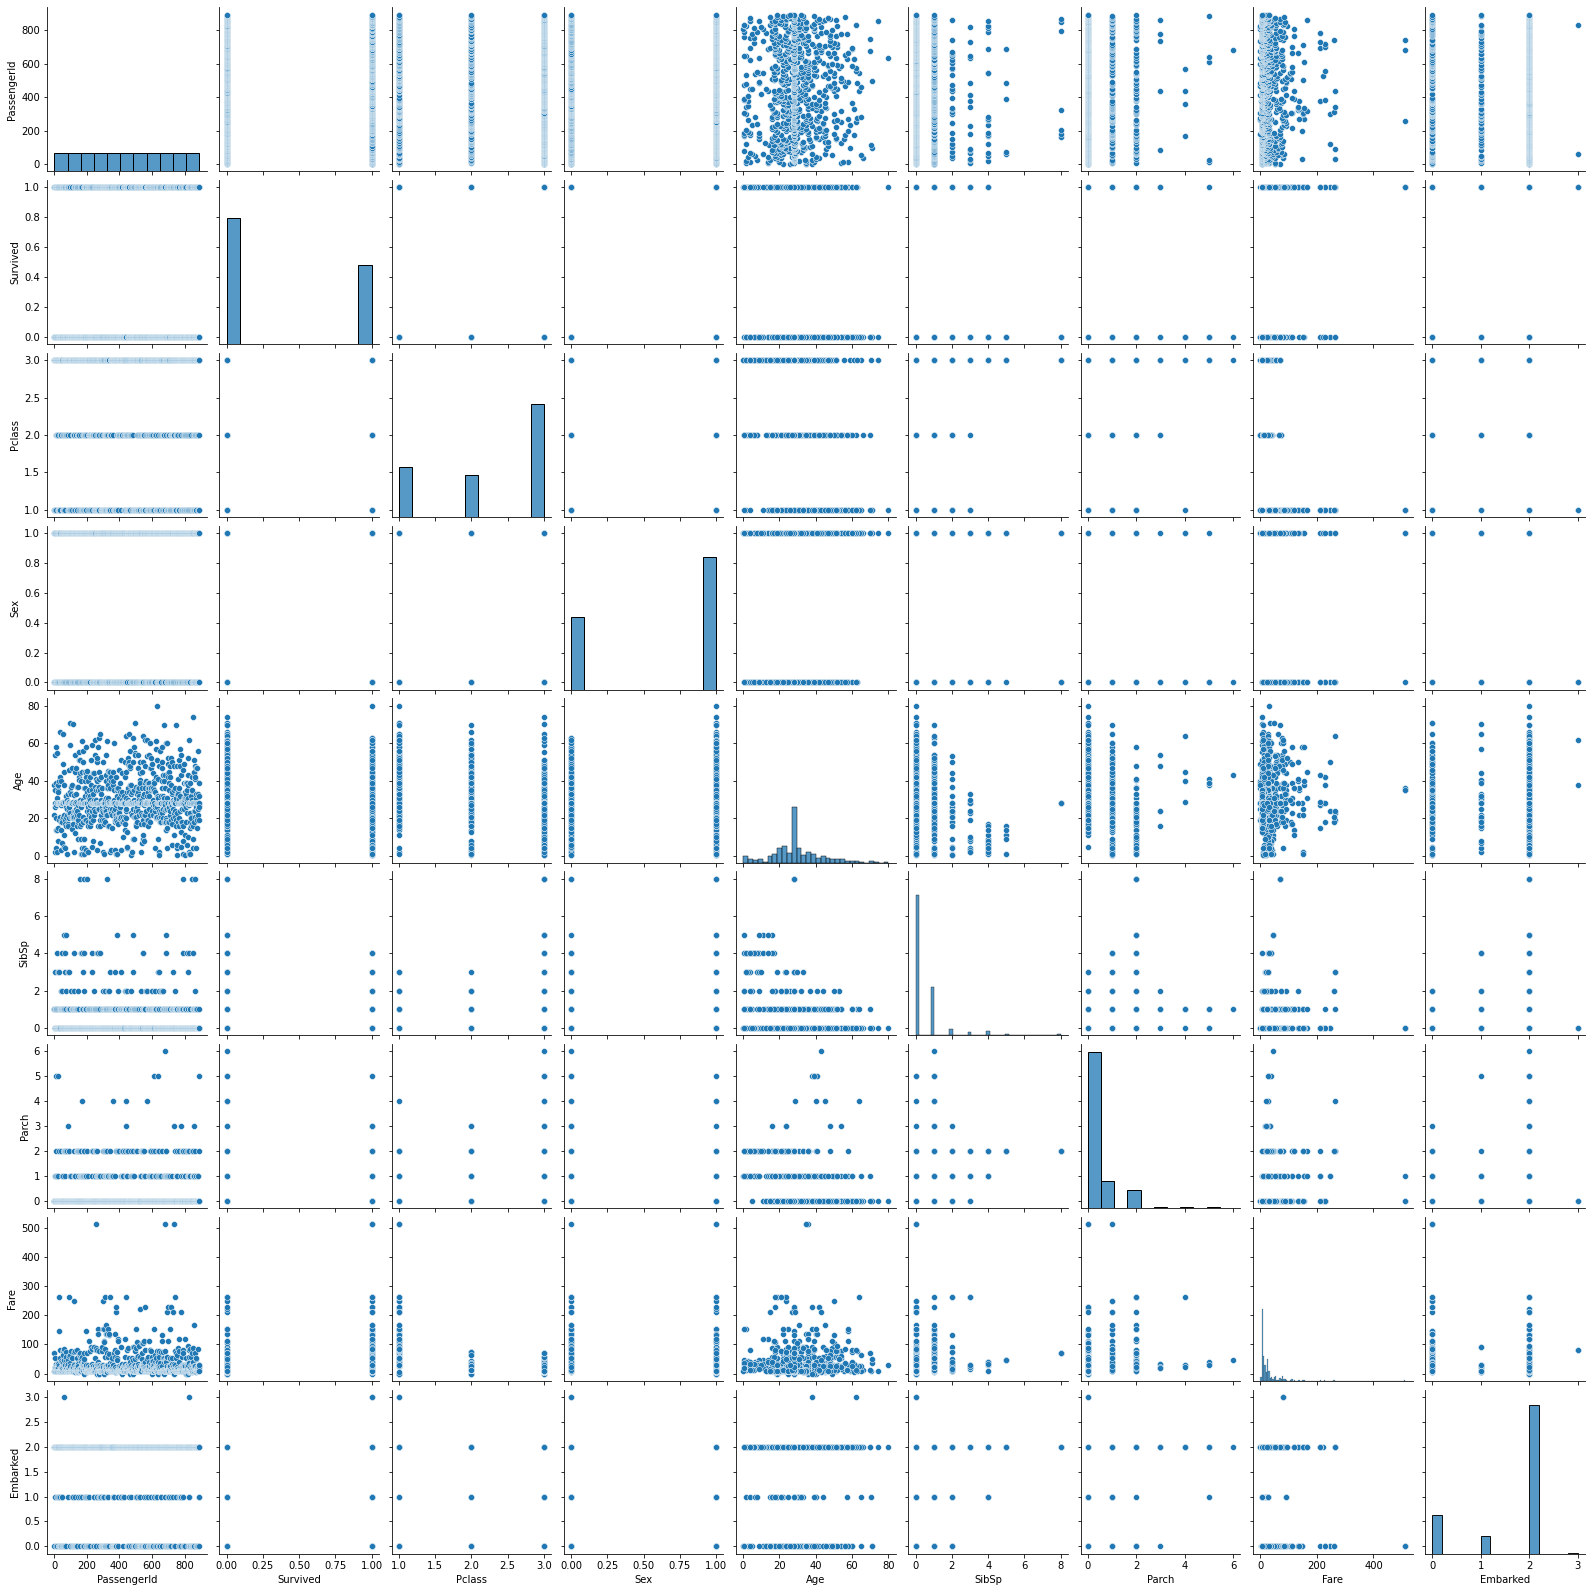

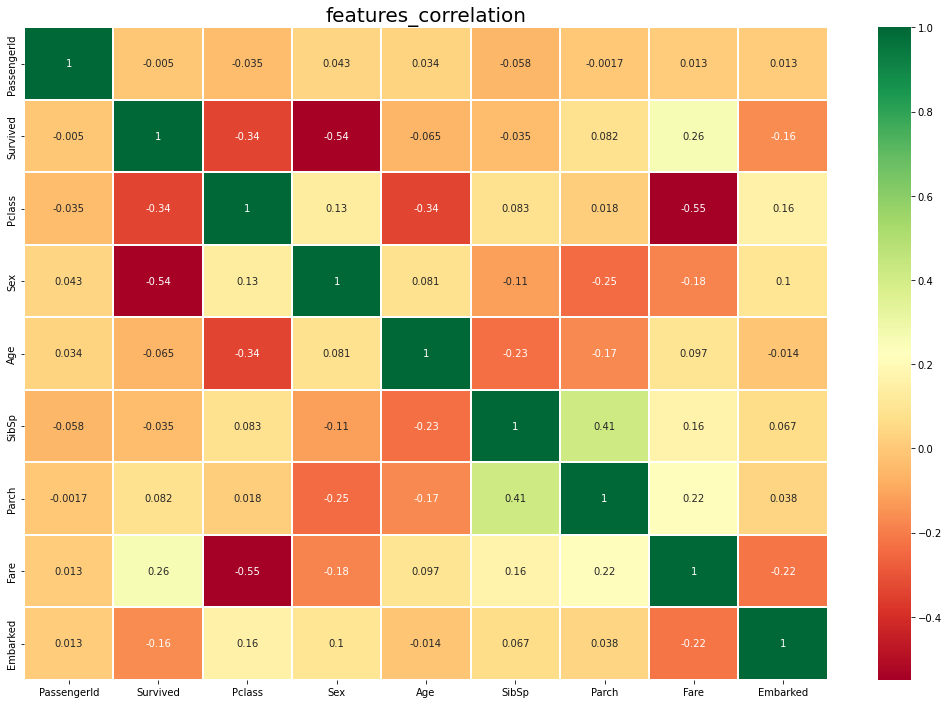

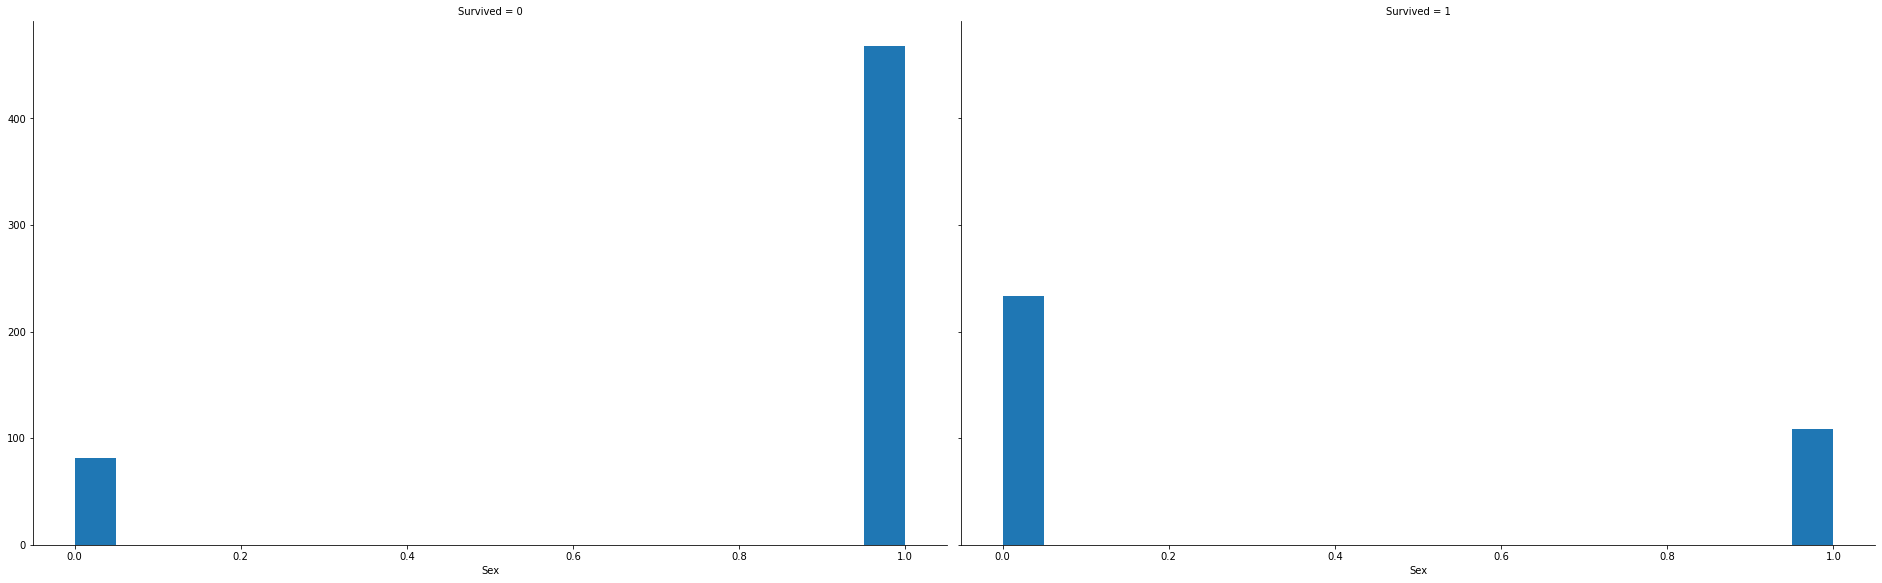

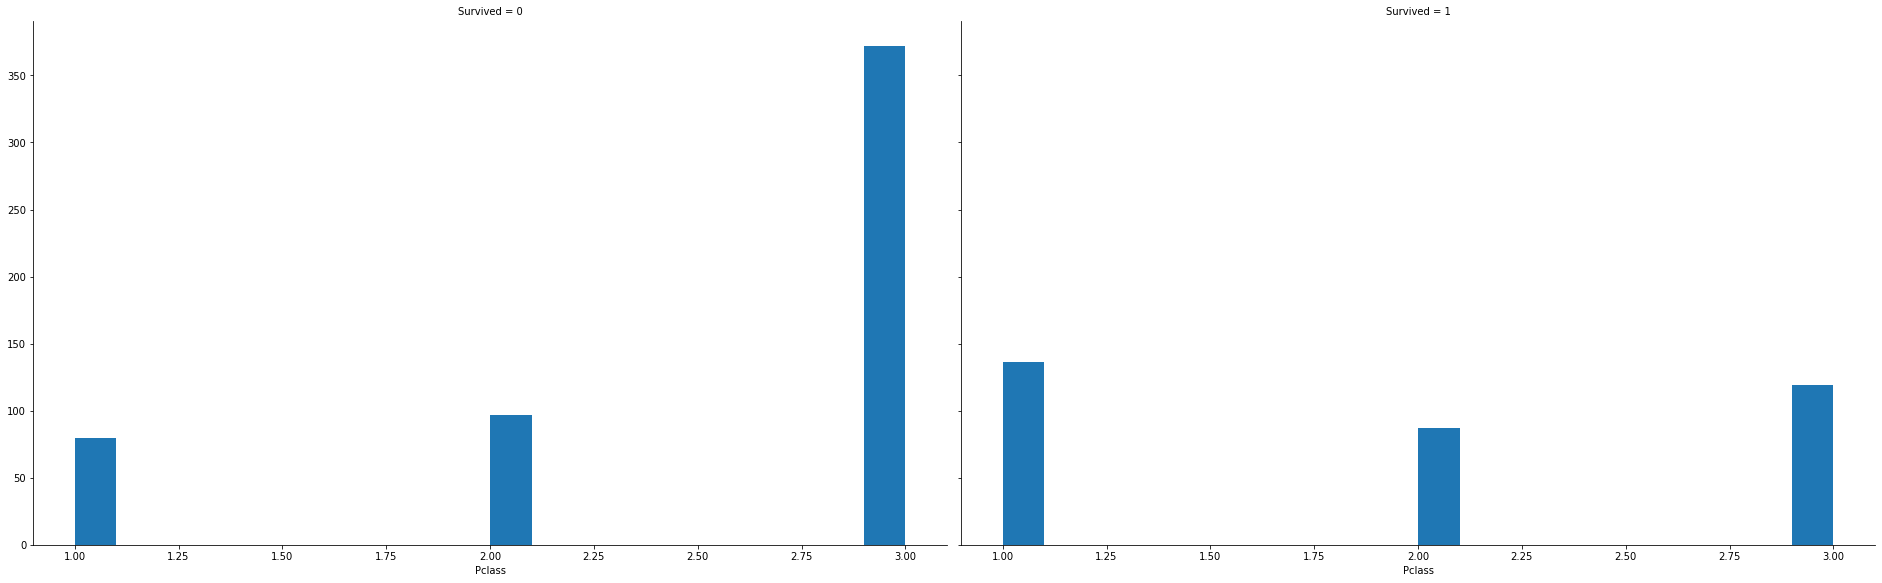

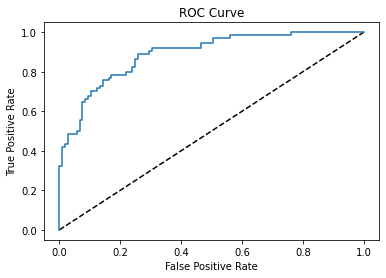

In [14]:
path='Z:/Workspace/ITi/Data Science in Production/TitanicMlflowProject/data/Titanic.csv'
repo='Z:/Workspace/ITi/Data Science in Production/TitanicMlflowProject'

# versions="v0" # Original Dataset with null, DO NOT USE !!
# versions="v1" # Drop Null Cols
# versions="v2" # Drop Null Rows
versions="v3" # Impute Null Values With Median.
resource_url2 = dvc.api.get_url(
    path=path,
    repo=repo,
    rev = versions
    )
print('-----')
print(resource_url2)   

# read our Data
df = pd.read_csv(resource_url2, sep=',', index_col=False)

PrintInfo(df) # print df info

category_cols=['Sex','Embarked']
df = labelEncoding(df, category_cols) # Label encoding

DataAnlysis(df) # Data Anlysis
DataViz(df) # Data visualization 

X_df=df.drop(['PassengerId','Name','Survived','Ticket'], axis=1)
y_df=df['Survived']

X_train, X_test, y_train, y_test =train_test_split(X_df, y_df, test_size=0.2, random_state=42) # split our data

models = {'qda': QuadraticDiscriminantAnalysis(),# QuadraticDiscriminantAnalysis Classifier
          'ada_clf':AdaBoostClassifier(), # ada Classifier
          'cv':GridSearchCV(estimator=Pipeline([('scaler', StandardScaler()),('knn', KNeighborsClassifier())]), param_grid={'knn__n_neighbors': np.arange(1, 50)}), # Grid Search - Knn Classifier
          'log':LogisticRegression(penalty = 'l2',solver = 'liblinear', C = 0.25),
         }
results = VotingCls(models, X_train, X_test, y_train, y_test)


remote_server_uri = "http://127.0.0.1:5000" # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)
# Note: on Databricks, the experiment name passed to mlflow_set_experiment must be a
# valid path in the workspace
mlflow.set_experiment("/Titanic_Project")
with mlflow.start_run():
    mlflow.log_param("Requested Version", versions)
    mlflow.log_param("Requested Version path", resource_url2)
    mlflow.log_param("Requested Version Count", len(df))
    mlflow.log_param("Requested Version Train Score", results['TrainScore'])
    mlflow.log_param("Requested Version Test Score", results['TestScore'])
    mlflow.log_param("Requested Version MSE", results['MSE'])
    mlflow.log_param("Requested Version MSLE", results['MSLE'])
    